# Mnist Classifier From Scratch
---

Notebook ini menyediakan implementasi langsung dari *Deep Neural Network (DNN)* menggunakan NumPy. Dengan tidak menggunakan library tingkat tinggi seperti TensorFlow atau PyTorch, latihan ini berfokus pada membangun komponen inti secara manual untuk lebih memahami bagaimana *Neural network* bekerja secara mendalam — termasuk proses forward pass, backward pass, pembaruan weight, dan training loop.

In [3]:
import os
import requests
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import random
import gzip
import shutil

## 1. Download Mnist Dataset and Unzip
---

**MNIST** (Modified National Institute of Standard and Technology) adalah kumpulan data besar yang terdiri dari gambar digit tulisan tangan. MNIST sendiri berisi 60.000 gambar untuk data training dan 10.000 gambar untuk data testing. Dalam dataset ini, digit telah dinormalisasi ukurannya dan dipusatkan dalam gambar berukuran 28x28 piksel.

In [4]:
# https://github.com/cvdfoundation/mnist?tab=readme-ov-file
DATA_DIR = "/app/dataset/MNIST"
os.makedirs(DATA_DIR, exist_ok=True)

In [5]:

def download_mnist():
    MNIST_FILES = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
    }
    for name, url in MNIST_FILES.items():
        out_path = os.path.join(DATA_DIR, url.split('/')[-1])
        result_path = out_path[:-3] 
        if not os.path.exists(result_path):
            if not os.path.exists(out_path):
                print(f"Downloading {name}...")
                r = requests.get(url)
                with open(out_path, 'wb') as f:
                    f.write(r.content)
            else:
                print(f"{name} already downloaded.")
            print(f"Unzipping {out_path}...")
            with gzip.open(out_path, 'rb') as f_in:
                with open(result_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        
        else:
            print(f"{name} already unzipped.")

In [6]:
download_mnist()

train_images already unzipped.
train_labels already unzipped.
test_images already unzipped.
test_labels already unzipped.


In [7]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    print(folder + "/" + prefix + '-images-idx3-ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "/app/dataset/MNIST" )
testImages, testLabels = loadMNIST( "t10k", "/app/dataset/MNIST" )

/app/dataset/MNIST/train-images-idx3-ubyte
/app/dataset/MNIST/t10k-images-idx3-ubyte


## 2. Preprocess the Data


Untuk menyiapkan data MNIST agar dapat digunakan dalam pelatihan *Neural Network*, dua langkah praproses dilakukan:

- **Normalisasi Nilai Piksel**: Nilai piksel dalam gambar biasanya berkisar antara 0 hingga 255. Nilai-nilai ini dinormalisasi ke rentang 0 hingga 1 dengan membagi setiap piksel dengan 255. Proses ini membantu network belajar dengan lebih efektif.

- **One-hot Encoding Label**: Label dikonversi ke vektor one-hot encoding untuk merepresentasikan kelas kategori dalam format yang dapat dipahami oleh neural network. Dalam vektor one-hot, setiap kategori direpresentasikan oleh sebuah vektor (array) dengan $N$ elemen, di mana $N$ adalah jumlah kategori.
![Representasi vektor one-hot](https://developers.google.com/static/machine-learning/crash-course/images/vocabulary-index-sparse-feature.svg)

In [ ]:
def toHotEncoding( classification ):
    # emulasi fungsi tensorflow tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

In [9]:
X_train = trainingImages / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = testImages / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)

y_train = toHotEncoding( trainingLabels )
y_test = toHotEncoding( testLabels )

### 2.1 Show Sample image from the dataset
Untuk memahami lebih baik struktur dan tampilan satu gambar dari MNIST, data tersebut bisa divisualisasikan menggunakan matplotlib. 

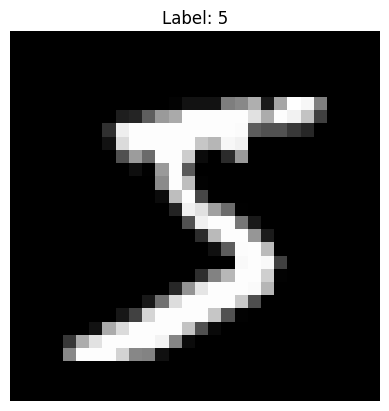

In [11]:
i = 0

image = trainingImages[i]  
label = trainingLabels[i]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## 3. Split Dataset to Training and Testing
---

Setelah proses preprocess selesai, dataset kemudian **diacak** agar data pelatihan dan pengujian memiliki sebaran yang representatif terhadap keseluruhan data. Setelah diacak, data **dibagi** menjadi 80% untuk training dan 20% untuk testing, agar performa model dapat dievaluasi menggunakan data yang belum pernah dilihat sebelumnya.

In [ ]:
# Acak training set
indices = np.random.permutation(X_train.shape[0])
X_train = X_train[indices]
y_train = y_train[indices]

# Bagi training dan testing data ke rasio 80:20
split_index = int(X_train.shape[0] * 0.8)
X_test = X_train[split_index:]
y_test = y_train[split_index:]
X_train = X_train[:split_index]
y_train = y_train[:split_index]

# Uncomment jika memakai library
# from sklearn.model_selection import train_test_split    
# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train, test_size=0.2, random_state=42, shuffle=True
# )

# print out the shape of each
# Gambar training: 60000 gambar with 784 kolom(tiap gambar 28x28, jika satu dimensi 784)
# Label training: has 60000 label dengan 10 kolom

print(f"{X_train.shape}:{y_train.shape}")
print(f"{X_test.shape}:{y_test.shape}")

(48000, 784):(48000, 10)
(12000, 784):(12000, 10)


## 4. Define Activation Functions
---

Dalam proses pelatihan/training, sebuah **fungsi aktivasi** digunakan untuk mengenali pola-pola kompleks dan tidak linier antara input dan target. Fungsi ini mengubah output mentah (logits) menjadi bentuk yang lebih berguna dengan menerapkan operasi matematika tertentu. Ada berbagai jenis fungsi aktivasi, masing-masing memiliki kelebihan dan kegunaan yang berbeda.

<br>

**SoftMax**

\begin{align*}
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad \text{untuk } i = 1, 2, \dots, K
\end{align*}

Softmax adalah fungsi yang menghasilkan probabilitas untuk setiap kelas yang mungkin ($K$) dalam kasus klasifikasi multi-kelas. Jumlah total probabilitas akan selalu sama dengan 1.0.


**ReLU**

\begin{align*}
\text{ReLU}(x) =
\begin{cases}
x & \text{jika } x > 0 \\
0 & \text{jika } x \leq 0
\end{cases}
\end{align*}

ReLU (Rectified Linear Unit) adalah fungsi yang hanya menghasilkan output jika input bernilai positif. Meskipun sederhana, ini adalah salah satu fungsi aktivasi yang paling populer digunakan.


**Sigmoid**

\begin{align*}
sigmoid(x) = \frac{1}{1 + e^{-\text{x}}}
\end{align*}

Sigmoid adalah fungsi yang memetakan nilai input apa pun ke dalam rentang antara 0 dan 1. Namun, fungsi ini memiliki kekurangan berupa masalah vanishing gradient — ketika input sangat besar atau kecil, gradien menjadi sangat kecil, yang bisa memperlambat atau menghentikan proses belajar.


**Leaky ReLU**

\begin{align*}
\text{LeakyReLU}(x) =
\begin{cases}
x & \text{jika } x \geq 0 \\
\alpha x & \text{jika } x < 0
\end{cases}
\quad \text{dengan } \alpha \in (0, 1)
\end{align*}

Leaky ReLU adalah variasi dari ReLU yang memberikan kemiringan kecil untuk nilai negatif, bukan nol. Fungsi ini sering digunakan saat melatih model generatif seperti GAN.


**TanH**

\begin{align*}
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{2}{1 + e^{-2x}} - 1
\end{align*}

TanH adalah fungsi yang menghasilkan output dalam rentang -1 hingga 1, sehingga lebih baik dalam menangani input negatif dibandingkan fungsi seperti Sigmoid yang hanya menghasilkan nilai antara 0 dan 1.


**Masih banyak lagi...**

Karena fungsi aktivasi mengubah hasil mentah menjadi representasi yang lebih bermakna lewat operasi matematika, ada banyak kemungkinan untuk membuat variasi fungsi baru sesuai kebutuhan.

<br>

In [ ]:
def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# setiap aktivasi berada didalam sebuah map, 
# berguna untuk langsung mengambil derivatifnya di backpropagation
activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: np.ones_like(x))  # No activation
}

## 5. Define Loss Function and Metrics
---

Dalam *Deep Learning*, **fungsi loss** adalah ukuran seberapa jauh prediksi dari model dibandingkan dengan label sebenarnya. Tujuan dari pelatihan adalah untuk meminimalkan nilai loss ini, yang berarti prediksi model semakin mendekati nilai yang sebenarnya. Beberapa fungsi loss yang umum digunakan:

- **Mean Squared Error (MSE)**: digunakan untuk tugas regresi.
- **Cross-Entropy Loss**: digunakan untuk tugas klasifikasi, dan sering dipasangkan dengan fungsi aktivasi **Softmax** dalam kasus klasifikasi multi-kelas.

Sementara itu, **metrik** digunakan untuk mengevaluasi performa model, namun tidak digunakan secara langsung dalam proses optimisasi model seperti fungsi loss. Beberapa metrik umum antara lain:

- **Akurasi**: Persentase prediksi model yang benar.
- **Presisi, Recall, dan F1-Score**: Cocok digunakan untuk dataset yang tidak seimbang, terutama dalam klasifikasi biner.
- **AUC-ROC**: Mengukur area di bawah kurva ROC, sering digunakan untuk menilai performa klasifikasi biner.


In [ ]:

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

def accuracy(y_pred, y_true):
    # Ambil indeks kelas
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Ubah one-hot menjadi indeks kelas jika diperlukan
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

## 6. Define Layer Class

<!-- ![neural network](img/neuralnetwork.png) -->
<p align="center">
  <img src="img/neuralnetwork.png"/>
</p>


Sebuah model dapat dianggap sebagai sistem yang terdiri dari beberapa **layer**, di mana setiap layer mengubah representasi data. Umumnya terdiri dari input layer, satu atau lebih hidden layer, dan output layer. Setiap layer melakukan transformasi linier, lalu menerapkan fungsi aktivasi untuk menangkap hubungan yang tidak linier.

- **layer Input**: Menerima data mentah dan meneruskannya ke layer berikutnya.

- **layer Tersembunyi (Hidden Layer)**: Memproses data melalui serangkaian transformasi, mempelajari pola dan fitur kompleks dari input. Setiap neuron di layer ini memberikan weight/bobot (seberapa penting sinyal tersebut) pada sinyal masuk, lalu menerapkan fungsi aktivasi untuk menghasilkan output yang akan diteruskan ke layer selanjutnya.

- **layer Output**: Menghasilkan prediksi akhir, bisa berupa probabilitas kelas, nilai regresi, atau bentuk output lain tergantung pada jenis tugas.

Selama proses pelatihan, model akan menghasilkan prediksi awal melalui **Forward Pass**, kemudian weight pada setiap layer disesuaikan menggunakan **Backward Pass (Backpropagation)**. Proses ini mengoptimalkan performa model dengan mengurangi kesalahan dari prediksi.


### 6.1 Forward Pass

\begin{align*}
z &= XW + b \\
y &= \phi(z)
\end{align*}

Where:

- $X$: Input data or activations dari layer seblumnya  
- $W$: Weight  
- $b$: Bias  
- $z$: Kobinasi linear inputs dan weight  
- $\phi(z)$: Fungsi aktivasi yang diterapkan pada $z$, menghasilkan output $y$

Forward pass adalah proses di mana data input dilewatkan melalui seluruh layer hingga menghasilkan output. Proses ini bisa dilakukan dengan menghitung satu per satu output dari neuron, tetapi lebih efisien jika diperlakukan sebagai operasi perkalian matriks.


##### Matrix Representation of a Forward Pass
Jika input terdiri dari $n$ fitur, input tersebut bisa disusun dalam bentuk baris datar. Saat ada $k$ data input, semuanya dapat ditumpuk secara vertikal menjadi sebuah matriks berukuran $(k, n)$ — $k$ baris dan $n$ kolom. Matriks ini dapat langsung dikalikan dengan **matriks weight** berukuran $(m, n)$, di mana $m$ adalah jumlah neuron di layer berikutnya. Tiap kolom mewakili weight untuk satu neuron, dan disusun secara horizontal.

Hasil perkalian tersebut adalah matriks berisi kombinasi linier dari input dan weight. Kemudian, **bias** ditambahkan pada setiap baris dari hasil tersebut. Hasil akhirnya adalah matriks keluaran mentah (sering disebut *logits*) $z$.

Setiap elemen dari matriks logits kemudian dilewatkan melalui fungsi aktivasi untuk menghasilkan output akhir $y$.

### 6.2 Backward pass
**Backward Pass** atau sering juga disebut *Backpropagation*, adalah proses untuk mengurangi error atau kesalahan dari prediksi dengan cara menyesuaikan bobot (weight) dari seluruh neuron pada semua layer tersembunyi. Untuk melakukannya, dibutuhkan perhitungan turunan dari error terhadap weight.

\begin{align*}
W_u &= W_0 - \alpha \frac{dE}{dW}
\end{align*}

Where:

- $W_u$ : Weight setelah backpropagation
- $W_0$ : Weight original sebelum update  
- $\alpha$ : Learning rate, nilai skalar yang mengontrol berapa banyak weight diubah
- $\frac{dE}{dW}$ : Turunan dari fungsi loss terhadap bobot

Pada awal pelatihan, weight $W$ diinisialisasi secara acak, dan nilai **learning rate** $\alpha$ ditentukan oleh pengguna. Yang perlu dihitung selanjutnya adalah **gradien pembaruan** $\frac{dE}{dW}$, yaitu turunan dari error terhadap weight, yang sangat penting dalam proses penyesuaian weight saat backward pass berlangsung.


<p align="center">
  <img src="img/backpropagation.png"/>
</p>

Seperti terlihat pada ilustrasi, untuk menghitung $ \frac{dE}{dW} $ (gradien pembaruan) dan membantu dalam pembaruan weight antar layer, ada beberapa komponen yang disimpan di tiap layer:

- $ \frac{dE}{dX} $: Gradien error terhadap input dari layer saat ini. Ini berguna untuk meneruskan error ke layer sebelumnya.

- $ \frac{dE}{dy} $: Gradien error yang diteruskan dari layer berikutnya. Gradien ini mengalir mundur dan menjadi titik awal untuk proses backpropagation.

- $ z_0 $: Nilai keluaran sebelum aktivasi $ z_0 = XW + b $, yang digunakan untuk menghitung turunan dari fungsi aktivasi.

- $ y_0 $: Nilai keluaran setelah fungsi aktivasi diterapkan, yaitu $ \phi(z_0) $. Nilai ini digunakan di proses forward maupun backward.

- $ X $: Input ke layer tersebut, yang diperlukan untuk menghitung gradien terhadap weight $ \frac{dE}{dW} $.


Untuk mengimplementasikan proses ini dalam kode, biasanya dibuat sebuah kelas Layer yang merepresentasikan layer dengan $m$ fitur input dan $n$ neuron output. Setelah dibuat, tiap objek layer akan menyimpan berbagai variabel seperti matriks weight $W$, vektor bias $b$, serta nilai-nilai seperti $X$, $z_0$, dan $y_0$ dari proses forward pass. Nilai-nilai ini kemudian digunakan ulang saat backpropagation untuk menghitung gradien dan memperbarui weight dengan efisien.

In [ ]:

class Layer():

    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # Inisialisasi weight dengan shape(input connection, neuron count)
        self.W = (np.random.randn(inFeature, outFeature) * np.sqrt(2 / (inFeature + outFeature))).astype(np.float64)
        # intialize bias dengan shape(1, neuron count)
        self.b = np.zeros((1, outFeature), dtype=np.float64)
        # Set layer menjadi trainable(gradien dapat berubah)
        self.trainable = True
        # Ambil aktivasi dari map(key:value pair)
        self.activation, self.activation_deriv = activation_map.get(activationFunction, (None, None))
        self.y = self.z = self.X = None

    #Fungsi Feed Forward
    def Forward(self, X, isInference):
        if isInference==True:
            return self.activation(X @ self.W + self.b)
        self.X = X
        # Kalkulasi output
        # z = W * X + b, with
        self.z = X @ self.W + self.b
        # Pasang Activation Fucntion
        # y = activation(z)
        self.y = self.activation(self.z)
        return self.y


    # Fungsi Back Propagation
    def BackwardHidden(self, dEdy, lr=0.01):
        # Menggunakan turunan dari fungsi aktivasi
        # cari perubahan output terhadap input
        dydx = self.activation_deriv(self.z)

        # Gunakan aturan rantai (chain rule) untuk mendapatkan dEdx
        dEdx = dEdy * dydx

        # Gunakan aturan rantai untuk mendapatkan dEdW
        # dEdW = dxdW * dEdx
        # di mana dxdW didefinisikan sebagai output dari layer sebelumnya / input layer ini, yaitu X 
        dEdW = self.X.T @ dEdx

        # dEdb = jumlah total perubahan error terhadap input
        dEdb = np.sum(dEdx, axis=0, keepdims=True)

        # Update parameter layer jika bisa dilatih
        # Weight baru = weight awal - learning rate * perubahan error terhadap weight
        # Bias baru = bias awal - learning rate * perubahan error terhadap bias
        if self.trainable:
            self.W -= lr * dEdW
            self.b -= lr * dEdb

        # Propagasi gradien ke layer sebelumnya
        # Hitung perubahan error terhadap output sebelumnya
        # dEdy = dEdx * dxdy
        # di mana dxdy adalah perubahan input terhadap output akhir,
        # yaitu seberapa besar kontribusinya terhadap output akhir. Dalam hal ini adalah W
        return dEdx @ self.W.T


## 7. Define Model Class
---

Untuk membantu proses forward pass, backward pass, dan pelatihan, digunakan sebuah **kelas model** yang menerima daftar layer saat dibuat. Di dalam kelas model ini, terdapat tiga metode utama:

- **ForwardProp**: Menjalankan forward pass melalui tiap layer, menghitung output berdasarkan weight dan aktivasi saat ini.

- **BackwardProp**: Menjalankan backward pass untuk menghitung gradien dan memperbarui weight menggunakan metode backpropagation.

- **Train**: Mengatur seluruh proses pelatihan, termasuk menjalankan forward dan backward pass dalam beberapa *epoch*, sambil menerapkan metode *gradient descent* untuk mengoptimalkan weight.


In [ ]:

class Model():
    
    # Buat model dengan layer
    def __init__(self, layers) -> None:
        self.layers = layers
    
    # Forward Propagation
    def ForwardProp(self, X, isinference=False):
        for layer in self.layers:
            X = layer.Forward(X, isinference)
        return X
    
    # Backward Propagation
    # Mulai dari layer terakhir
    def BackwardProp(self, dEdy, learningRate=0.01):
        for layer in reversed(self.layers):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)

    # Fungsi train untuk training
    def train(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, X_test=None, y_test=None):
        train_loss=[]
        train_metrics=[]
        test_loss=[]
        test_metrics=[]
        for epoch in range(epochs):
            # 1. Ambil raw output dengan Forward Propagation
            logits = self.ForwardProp(X_train)
            # 2. Gunakan softmax untuk mendapatkan probabilitas
            # Softmax tidak di output layer karena dapat disimlifikasi dengan CCE 
            probs = softmax(logits)
            # 3. Hitung loss and metrics
            loss = loss_fn(probs, y_train)
            metrics = metrics_fn(probs, y_train)
            train_loss.append(loss)
            train_metrics.append(metrics)
            # 4. Hitung perubahan error terhadap output dari layer terakhir
            # Turunan dari fungsi loss disederhanakan menjadi ypred - ytrue
            # dan hasilnya kemudian dibagi dengan ukuran batch-nya

            dEdy = (probs - y_train) / y_train.shape[0]
            # 5. Hitung gradien dan update parameter model dengan Backward Propagation
            # Lakukan prosedur yang sama dengan data testing dan tampilkan log hasilnya
            if X_test.shape and y_test.shape is not None:
                test_logits = self.ForwardProp(X_test, True)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f},")
            else:
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}")
            self.BackwardProp(dEdy, learningRate)

                
                
        return {"train_loss": train_loss,
             "train_metrics": train_metrics,
             "test_loss": test_loss,
             "test_metrics": test_metrics}



## 8. Build Model Object
---

Dengan menggunakan kelas **Layer** dan **Model** secara bersamaan, List layer dengan parameternya dapat didefiniskan dan kemudian diberikan ke objek Model yang dibuat. Dalam kasus MNIST, digunakan 2 layer dengan jumlah fitur input sebanyak 784 (karena gambar 28x28 piksel).

In [ ]:
layerSequence = [
    Layer(inFeature=784, outFeature=32,activationFunction="relu"),
    # Layer terakhir tanpa aktivasi
    Layer(inFeature=32, outFeature=10,activationFunction=None)  
]
model=Model(layerSequence)

### 8.1 Test Initial Prediction

Sebelum melatih model, ada baiknya untuk menguji performa awalnya terlebih dahulu. Pilih satu gambar secara acak dari dataset pengujian dan jalankan melalui model yang belum dilatih untuk melihat hasil prediksinya. Langkah ini berguna untuk memastikan bahwa model berjalan dengan benar serta memberikan prediksi awal yang bisa dijadikan perbandingan setelah pelatihan dilakukan.

True label: 9, Predicted label: 4


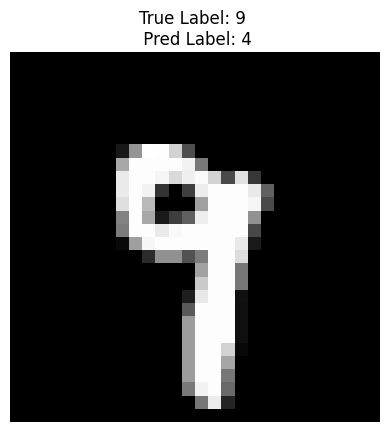

In [ ]:
# Ambil random image
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
# softmax
y_pred = softmax(y_logits)


# Ambil maksimum arraynya
predicted_class = np.argmax(y_pred)

# Tampilkan dengan matplotlib
print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 9. Train Model
---

Dengan menggunakan metode **train** yang didefinisikan dalam kelas **Model**, lakukan pelatihan *full-batch* dengan memasukkan dataset pelatihan dan pengujian. Metode ini akan menangani seluruh proses forward pass, perhitungan loss, backpropagation, dan pembaruan bobot untuk seluruh *epoch*. Hasil metrik pelatihan disimpan dalam sebuah dictionary.

In [18]:
# Train model
metrics=model.train(epochs=100, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=categorical_cross_entropy, metrics_fn=accuracy, learningRate=0.1)
losses=metrics["train_loss"]

Epoch: 0, Loss: 2.4039, Acc: 0.0560, Test Loss: 2.4022, Test Acc: 0.0583,
Epoch: 1, Loss: 2.3013, Acc: 0.1035, Test Loss: 2.3011, Test Acc: 0.1092,
Epoch: 2, Loss: 2.2351, Acc: 0.1526, Test Loss: 2.2357, Test Acc: 0.1544,
Epoch: 3, Loss: 2.1832, Acc: 0.2005, Test Loss: 2.1848, Test Acc: 0.2020,
Epoch: 4, Loss: 2.1377, Acc: 0.2444, Test Loss: 2.1400, Test Acc: 0.2416,
Epoch: 5, Loss: 2.0946, Acc: 0.2836, Test Loss: 2.0974, Test Acc: 0.2828,
Epoch: 6, Loss: 2.0519, Acc: 0.3240, Test Loss: 2.0549, Test Acc: 0.3203,
Epoch: 7, Loss: 2.0084, Acc: 0.3660, Test Loss: 2.0114, Test Acc: 0.3626,
Epoch: 8, Loss: 1.9636, Acc: 0.4100, Test Loss: 1.9667, Test Acc: 0.4051,
Epoch: 9, Loss: 1.9175, Acc: 0.4548, Test Loss: 1.9206, Test Acc: 0.4497,
Epoch: 10, Loss: 1.8708, Acc: 0.4971, Test Loss: 1.8739, Test Acc: 0.4913,
Epoch: 11, Loss: 1.8239, Acc: 0.5327, Test Loss: 1.8270, Test Acc: 0.5294,
Epoch: 12, Loss: 1.7772, Acc: 0.5648, Test Loss: 1.7803, Test Acc: 0.5613,
Epoch: 13, Loss: 1.7308, Acc: 0.592

### 9.1 Plot Loss Curves

Untuk mendapatkan informasi dan memvisualisasikan bagaimana model belajar, akan sangat membantu untuk memplot *training loss* dan akurasi seiring waktu. Ini bisa dilakukan dengan menggunakan library seperti matplotlib. Visualisasikan metrik ini berfungsi untuk menilai konvergensi, mendeteksi *overfitting*, dan mengevaluasi kinerja model sepanjang pelatihan.

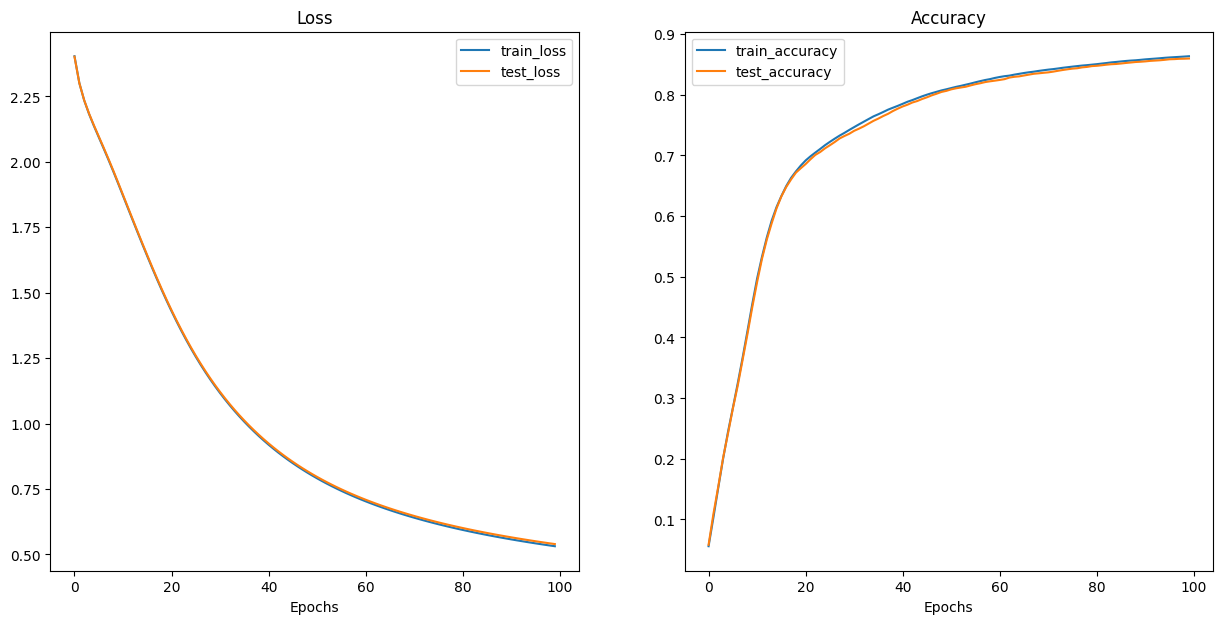

In [19]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_metrics"]
    test_accuracy = results["test_metrics"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

plot_loss_curves(metrics)

### 9.2 Test Trained Prediction
Setelah pelatihan selesai, evaluasi model dengan membuat prediksi pada gambar acak dari dataset pengujian. Selanjutnya, sel *kode* di bawah ini dapat dijalankan beberapa kali untuk melihat bagaimana kinerja model pada sampel yang berbeda.


True label: 3, Predicted label: 3


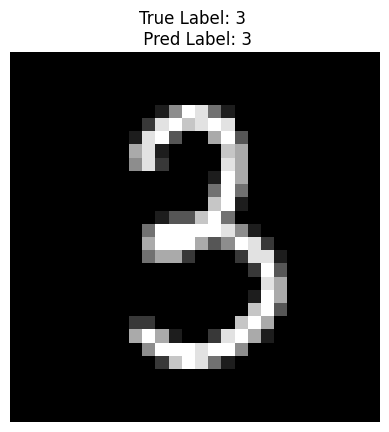

In [20]:
import random
i = random.randint(0,400)
image_raw=testImages[i]
image = testImages[i].reshape(1, -1) / 255.0  
label = testLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)



predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"True Label: {label} \n Pred Label: {predicted_class}")
plt.axis('off')
plt.show()

## 10. Build Confusion Matrix
---
Langkah terakhir, untuk mengevaluasi model secara tepat, tampilkan perbandingan antara nilai prediksi dan nilai aktual dengan **confusion matrix**. Confusion Matrix adalah tabel berukuran $N \times N$ yang merangkum jumlah prediksi yang benar dan salah yang dilakukan oleh model klasifikasi. Untuk masalah klasifikasi multi-kelas, matriks ini membantu mengidentifikasi pola kesalahan.

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Here in the confusion matrix, it can be clearly seen how much the model missclassifies, and how much it correctly classifies hand drawn digits

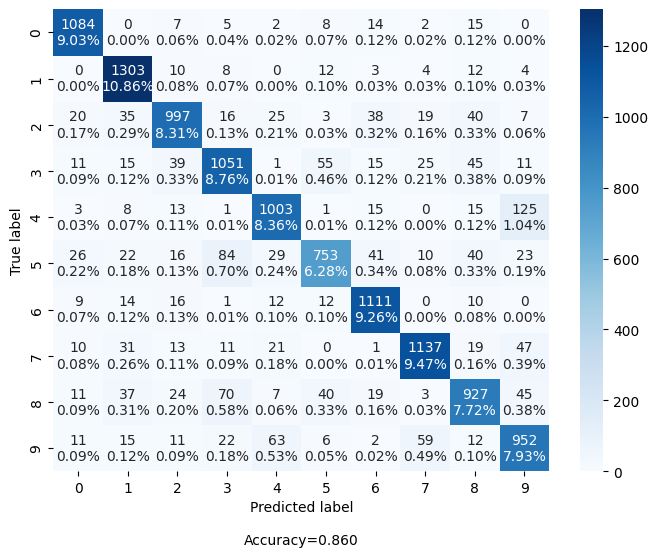

In [22]:
preds = softmax(model.ForwardProp(X_test))
y_true_cls = np.argmax(y_test, axis=1)
y_pred_cls = np.argmax(preds, axis=1)
cf_matrix = confusion_matrix(y_true_cls, y_pred_cls)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True,sum_stats=True)

## Credits
[Github- Mnist Dataset](https://github.com/cvdfoundation/mnist?tab=readme-ov-file)

[Dtuk - Confusion Matrix](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

[PapersWithCode - MNIST Dataset Explanation](https://paperswithcode.com/dataset/mnist)

[Google - One-hot encoding](https://developers.google.com/machine-learning/crash-course/categorical-data/one-hot-encoding)

[Google - Neural Network](https://developers.google.com/machine-learning/glossary#neural_network)

[Google - Activation Function](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/glossary)
